In [1]:
import traceback
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import os
import tempfile
import imageio as iio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('apikey.yml','r') as f:
    secret = yaml.safe_load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name=screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        if response.status_code == 200:
            with open(filepath,'wb') as f:
                f.write(response.content)
            image=iio.v3.imread(filepath)
            return image
        else:
            return None

In [4]:

# https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user
# API.get_user(*, user_id, screen_name, include_entities)

Lex Fridman lexfridman True Host of Lex Fridman Podcast.
Research Scientist at MIT.
Interested in robots and humans.
(48, 48, 3)


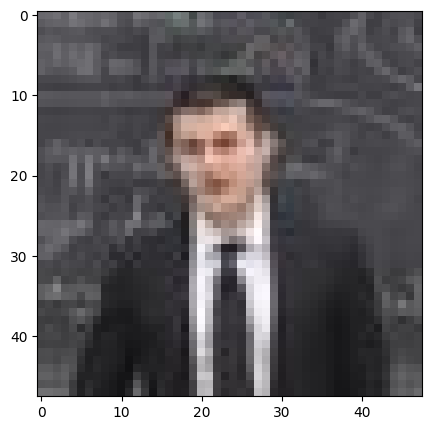

In [5]:
# @lexfridman
screen_name = 'lexfridman'
include_entities = True
user,profile_image = get_user_info(screen_name)

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

In [6]:
# https://docs.tweepy.org/en/stable/api.html?highlight=search_users#tweepy.API.search_users
# API.search_users(q, *, page, count, include_entities)
# 
# page – Specifies the page of results to retrieve. Note: there are pagination limits.
# count – The number of results to try and retrieve per page.

In [7]:
# set reference image and corresponding query using `user.name`

reference_screen_name = 'lexfridman'
user,reference_image = get_user_info(screen_name)
query = user.name

print(query)

Lex Fridman


In [8]:

# find  page_count*items_per_page count that matches the query
# API limit is 1k.
fetch = []
page_num = 10
count_per_page = 100

try:
    for x in range(page_num):
        print(f'querying page {x}')
        tmp = api.search_users(query,count=count_per_page,page=x)
        fetch.extend(tmp)
        if len(tmp)<count_per_page:
            break
except:
    traceback.print_exc()
    
print(len(fetch))

querying page 0
20


In [9]:
print(fetch[0])

User(_api=<tweepy.api.API object at 0x7f28ab4cb9a0>, _json={'id': 427089628, 'id_str': '427089628', 'name': 'Lex Fridman', 'screen_name': 'lexfridman', 'location': '', 'description': 'Host of Lex Fridman Podcast.\nResearch Scientist at MIT.\nInterested in robots and humans.', 'url': 'https://t.co/7AZXIygBjP', 'entities': {'url': {'urls': [{'url': 'https://t.co/7AZXIygBjP', 'expanded_url': 'https://lexfridman.com/podcast', 'display_url': 'lexfridman.com/podcast', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 1898778, 'friends_count': 2, 'listed_count': 5875, 'created_at': 'Sat Dec 03 03:06:19 +0000 2011', 'favourites_count': 6742, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': True, 'statuses_count': 2354, 'lang': None, 'status': {'created_at': 'Sun Oct 30 17:34:44 +0000 2022', 'id': 1586773611549016067, 'id_str': '1586773611549016067', 'text': "I'm thinking of coding up a bot that catches Twitter spam bots. Seems l

In [66]:

import time
# try to find a match based on profile image
mylist = []
profile_cache = {}
for n,x in enumerate(fetch):
    try:
        user,profile_image = get_user_info(x.screen_name)
        url = f'https://twitter.com/{user.screen_name}'
        # skip item if its reference
        if user.screen_name == reference_screen_name:
            print(user.screen_name)
            continue
        # if http error skip
        if profile_image is None:
            profile_cache[user.screen_name]=None
            continue
        # compute only if shape matches
        if profile_image.shape == reference_image.shape:
            item = dict(url=url,screen_name=user.screen_name,mean_diff=np.mean(profile_image-reference_image))
            profile_cache[user.screen_name]=profile_image.copy()
        else:
            item = dict(url=url,screen_name=user.screen_name,mean_diff=np.nan)
            profile_cache[user.screen_name]=None
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)
print(df.shape)

lexfridman
(19, 3)


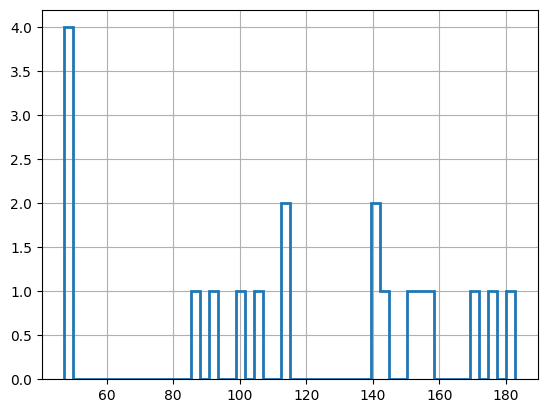

In [67]:
_=plt.hist(df.mean_diff,bins=50,histtype='step',linewidth=2)
plt.grid(True)

In [68]:
df = df.sort_values('mean_diff')

In [69]:
df

,url,screen_name,mean_diff
18,https://twitter.com/Puslica14,Puslica14,47.258681
14,https://twitter.com/rajjisharmakum1,rajjisharmakum1,47.258681
8,https://twitter.com/ErntzBellanger,ErntzBellanger,47.258681
5,https://twitter.com/Adio2022Adio,Adio2022Adio,47.258681
15,https://twitter.com/lexfridmanbot,lexfridmanbot,86.106047
0,https://twitter.com/zbitter,zbitter,91.809317
12,https://twitter.com/LexFridman__,LexFridman__,100.765914
10,https://twitter.com/lexpodbytes,lexpodbytes,106.168547
11,https://twitter.com/fatlexfridman,fatlexfridman,112.446615
13,https://twitter.com/Darkhorseduo1,Darkhorseduo1,114.148727


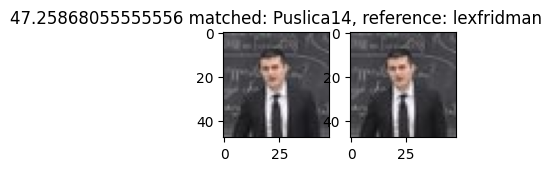

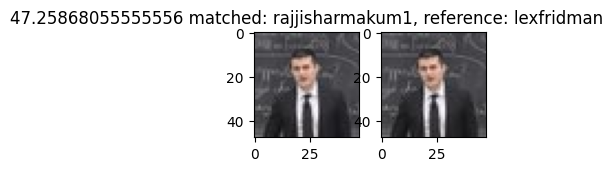

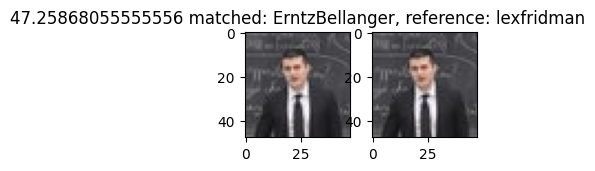

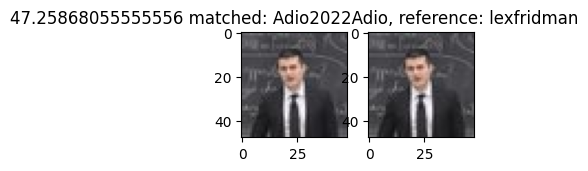

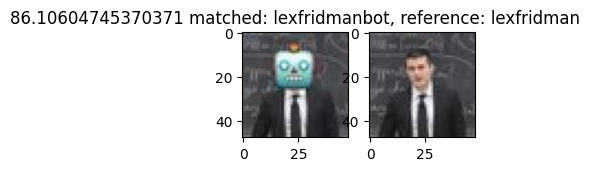

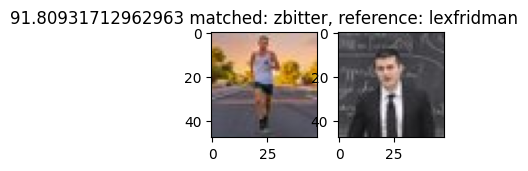

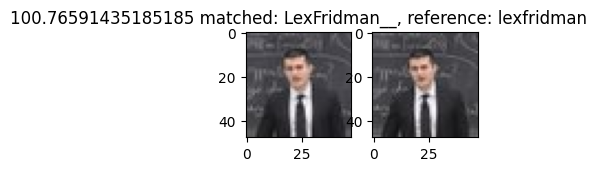

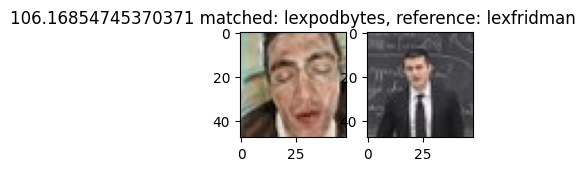

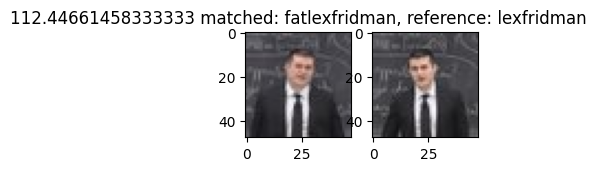

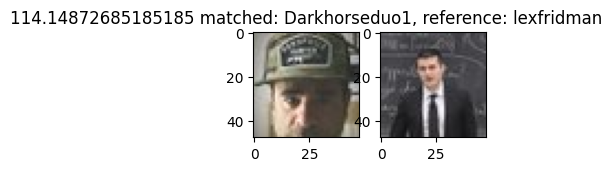

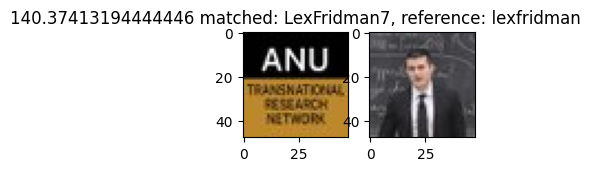

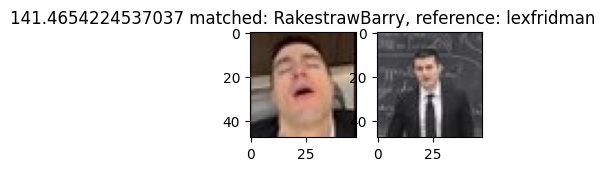

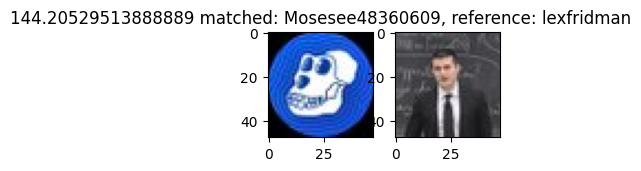

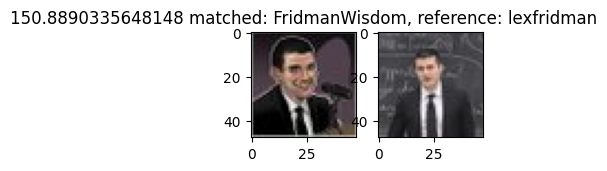

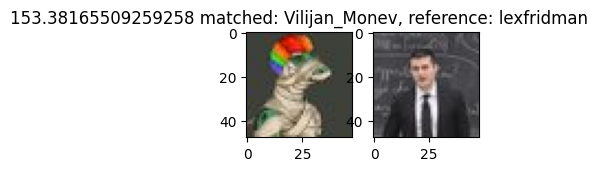

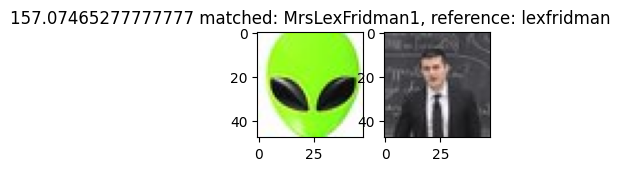

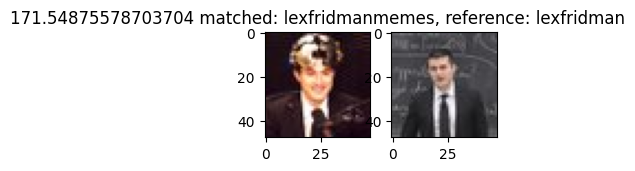

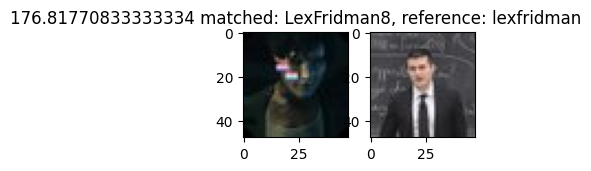

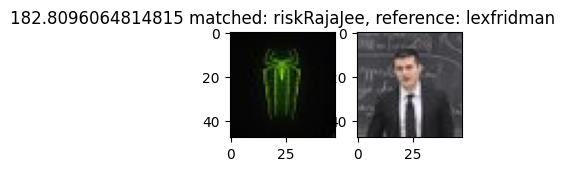

In [70]:
for n,row in df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'{row.mean_diff} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)

In [63]:
th = 101 #??? why is this not zero?
likely_matched_df = df[df.mean_diff < th]

In [64]:
likely_matched_df

,screen_name,mean_diff
18,Puslica14,47.258681
14,rajjisharmakum1,47.258681
8,ErntzBellanger,47.258681
5,Adio2022Adio,47.258681
15,lexfridmanbot,86.106047
0,zbitter,91.809317
12,LexFridman__,100.765914


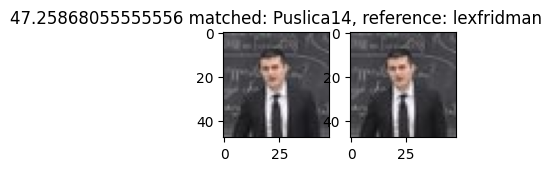

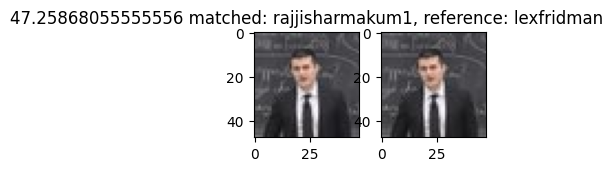

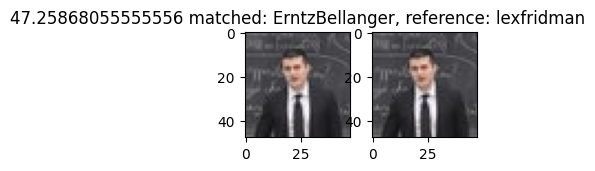

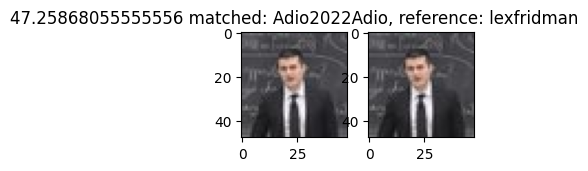

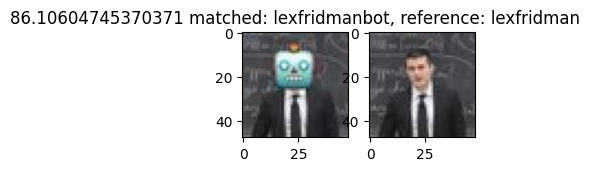

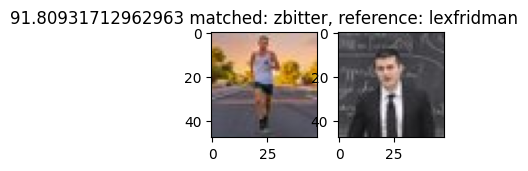

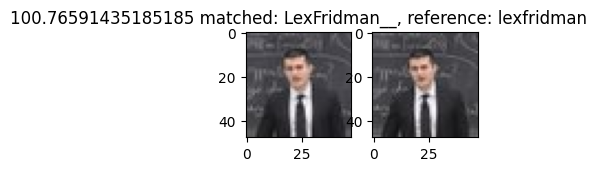

In [65]:
for n,row in likely_matched_df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'{row.mean_diff} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)